In [1]:
# Turn off warnings
import warnings
warnings.filterwarnings('ignore')

# Import the dependencies
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
from functools import reduce

from joblib import Parallel, delayed
from scipy.stats import entropy

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score, mutual_info_score, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get references to the data collections
data1 = db['ELR_Data']
data2 = db['Encoded_Gov_Data']
data3 = db['Encoded_SSS_Data']

In [3]:
# Create a dataframe from the ELR_Data collection
combined_df = pd.DataFrame(list(data1.find()))

# Create a dataframe from the Gov_Clusters collection
gc_df = pd.DataFrame(list(data2.find()))

# Create a dataframe from the SSS_Cluster collection
sc_df = pd.DataFrame(list(data3.find()))

In [4]:
# Create a copy of the original combined dataframe
ori_df = combined_df.copy()

# Drop the database id data and refresh the index
combined_df = combined_df.drop(['_id', 'Country', 'Year'], axis=1)
gc_df['Country_Year'] = combined_df['Country_Year']
sc_df['Country_Year'] = combined_df['Country_Year']

combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.set_index('Country_Year')
combined_df = combined_df.drop(['Gov Type', 'SSS Type'], axis=1)

gc_df = gc_df.drop(['_id'], axis=1)
gc_df = gc_df.reset_index(drop=True)
gc_df = gc_df.set_index('Country_Year')

sc_df = sc_df.drop(['_id'], axis=1)
sc_df = sc_df.reset_index(drop=True)
sc_df = sc_df.set_index('Country_Year')

In [5]:
# Collect the column labels so they can be reapplied after data scaling
numeric_col_names = combined_df.columns.tolist()

# Standardize the data with MaxAbsScaler(). Using this scaler to maintain integrity of sparse encoded values.
scaler = MaxAbsScaler()
scaled_nda = scaler.fit_transform(combined_df)

# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scaled_df = pd.DataFrame(scaled_nda, index=combined_df.index)

# Apply the column labels to ensure the data is properly identified
scaled_df = scaled_df.set_axis(numeric_col_names, axis=1)

In [6]:
# Merge the cluster DataFrames with the primary data.
frames = [scaled_df, gc_df, sc_df]
complete_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [7]:
complete_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_2001,0.4,0.458333,0.006107,0.002159,0.001669,0.884692,0.154266,0.994220,0.290291,0.021127,...,0,0,0,0,0,0,0,1,0,0
Albania_2007,0.4,0.458333,0.005927,0.002096,0.001575,0.907032,0.144535,0.994285,0.279641,0.035456,...,0,0,0,0,0,0,0,1,0,0
Albania_2010,0.4,0.458333,0.005813,0.002056,0.001625,0.911558,0.148214,0.996442,0.305632,0.051328,...,0,0,0,0,0,0,0,1,0,0
Albania_2021,0.4,0.458333,0.005663,0.001984,0.001771,0.894330,0.223448,1.000000,0.326236,0.076531,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2012,0.2,0.202778,0.001875,0.009360,0.006307,0.650615,0.009493,0.440000,0.338892,0.013887,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2013,0.2,0.202778,0.001916,0.009565,0.006462,0.672043,0.009731,0.406442,0.348271,0.015323,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2017,0.2,0.202778,0.002085,0.010409,0.007195,0.710067,0.021241,0.439791,0.311735,0.019327,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Prepare the visualization dataframe
frames = [combined_df, gc_df, sc_df]
viz_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [9]:
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_2001,2,1485.0,111.685146,3.060173,1.304704,75.639,13.00,99.421989,5.925833,247.234911,...,0,0,0,0,0,0,0,1,0,0
Albania_2007,2,1485.0,108.394781,2.970017,1.231498,77.549,12.18,99.428452,5.708428,414.916862,...,0,0,0,0,0,0,0,1,0,0
Albania_2010,2,1485.0,106.314635,2.913021,1.270655,77.936,12.49,99.644203,6.238996,600.657527,...,0,0,0,0,0,0,0,1,0,0
Albania_2021,2,1485.0,103.571131,2.811666,1.384740,76.463,18.83,100.000000,6.659588,895.594816,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2012,1,657.0,34.290632,13.265331,4.931171,55.626,0.80,44.000000,6.917949,162.515498,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2013,1,657.0,35.040512,13.555422,5.051977,57.458,0.82,40.644161,7.109403,179.320458,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2017,1,657.0,38.131320,14.751101,5.625665,60.709,1.79,43.979065,6.363585,226.177220,...,0,0,0,0,0,0,0,0,0,0


### Determine number of components for PCA ###

In [10]:
# Function to compute Minimum Average Partial (MAP) Criterion using Velicer's MAP test
def calculate_map(data, max_components):
    map_values = []
    for num_components in range(2, max_components + 1):
        pca_model = PCA(n_components=num_components)
        pca_model.fit(data)
        pca_data = pca_model.transform(data)
        
        # Calculate the partial correlation matrix
        partial_corr_matrix = np.corrcoef(pca_data, rowvar=False)
        
        # Remove the variance explained by the extracted components
        for i in range(pca_data.shape[1]):
            partial_corr_matrix[i, i] = np.nan
        
        # Calculate the average squared partial correlation
        average_squared_partial_correlation = np.nanmean(partial_corr_matrix ** 2)
        map_values.append(average_squared_partial_correlation)
    
    # Find the number of components just before the MAP value starts to increase
    components_to_retain_map = np.argmin(map_values) + 1
    
    return components_to_retain_map, map_values

In [11]:
# Function to compute the viable PCA components for a given dataset

def compute_pca(input_data):
    # Generate random data with similar scale to actual data
    std_devs = np.std(input_data, axis=0)
    mean_vals = np.mean(input_data, axis=0)
    random_data = np.random.normal(mean_vals, std_devs, input_data.shape)
    
    # Fit PCA on random data
    pca_random = PCA().fit(random_data)
    random_eigenvalues = pca_random.explained_variance_
    
    # Fit PCA on actual data
    pca_actual = PCA().fit(input_data)
    actual_eigenvalues = pca_actual.explained_variance_

    # Get the total number of eigenvalues
    total_eigenvalues = actual_eigenvalues.shape[0]
    print(f"Total number of actual eigenvalues: {total_eigenvalues}")
    
    # Compare eigenvalues and determine the number of components to retain
    components_to_retain_parallel = np.sum(actual_eigenvalues > np.percentile(random_eigenvalues, 95))
    print(f"Number of components to retain based on Parallel Analysis: {components_to_retain_parallel}")
    
    # Apply Kaiser Criterion
    components_to_retain_kaiser = np.sum(actual_eigenvalues > 1)
    print(f"Number of components to retain based on Kaiser Criterion: {components_to_retain_kaiser}")
    
    max_components = 10  # Provide a limit for the calculation
    components_to_retain_map, map_values = calculate_map(input_data, max_components)
    print(f"Number of components to retain based on MAP Criterion: {components_to_retain_map}")
    
    plt.plot(np.cumsum(pca_actual.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

Total number of actual eigenvalues: 19
Number of components to retain based on Parallel Analysis: 2
Number of components to retain based on Kaiser Criterion: 0
Number of components to retain based on MAP Criterion: 8


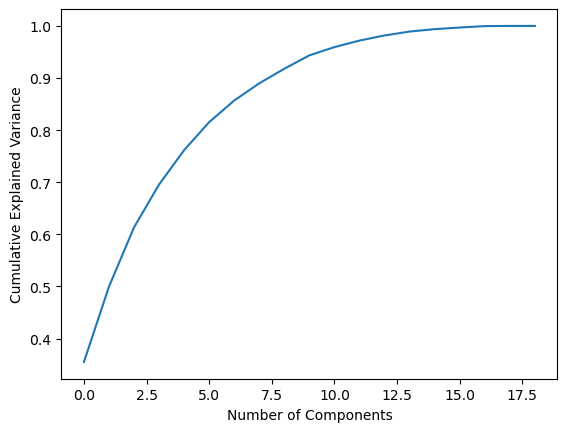

In [12]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(scaled_df)

Total number of actual eigenvalues: 109
Number of components to retain based on Parallel Analysis: 7
Number of components to retain based on Kaiser Criterion: 0
Number of components to retain based on MAP Criterion: 2


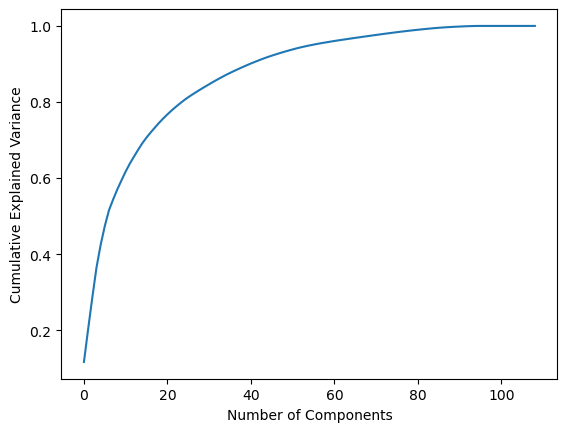

In [13]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(complete_df)

### Determine the number of clusters for this dataset ###

In [14]:
# Use KMedoids and compute Davies-Bouldin scores, elbow curve, and silhouette scores to determine the optimal number of clusters.

def compute_clusters(data_in):
    # Initializations
    davies_bouldin_scores = []
    distortions = []
    silhouette_avg_scores = []
    num_cluster = []
    
    # Range of the number of clusters to try
    range_n_clusters = range(2, 10)
    
    # Pre-compute the silhouette scores and clustering results to avoid repeated computation
    clustering_results = {}
    for n_clusters in range_n_clusters:
        # Initialize the clusterer with n_clusters value and random state for reproducibility
        clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++')
        cluster_labels = clusterer.fit_predict(data_in)
    
        # Store results for later use
        clustering_results[n_clusters] = {
            'clusterer': clusterer,
            'cluster_labels': cluster_labels,
            'cluster_centers': clusterer.cluster_centers_,
            'silhouette_avg': silhouette_score(data_in, cluster_labels),
            'silhouette_values': silhouette_samples(data_in, cluster_labels)
        }
    
        # Compute the scores for various metrics
        num_cluster.append(n_clusters)
        davies_bouldin_scores.append(davies_bouldin_score(data_in, cluster_labels))
        distortions.append(clusterer.inertia_)
        silhouette_avg_scores.append(clustering_results[n_clusters]['silhouette_avg'])
    
    # Plotting silhouette analysis and computing metrics at the same time
    for n_clusters in range(2, 10): 
        # Retrieve results from the dictionary
        clusterer = clustering_results[n_clusters]['clusterer']
        cluster_labels = clustering_results[n_clusters]['cluster_labels']
        cluster_centers = clustering_results[n_clusters]['cluster_centers']
        silhouette_avg = clustering_results[n_clusters]['silhouette_avg']
        sample_silhouette_values = clustering_results[n_clusters]['silhouette_values']
    
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(18, 7)
    
        # The 1st subplot is the silhouette plot. The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(data_in) + (n_clusters + 1) * 10])
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
    
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("Silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="dotted")
    
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        # Perform PCA for dimensionality reduction (for visualization only)
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data_in)
        cluster_centers_2D = pca.transform(cluster_centers)
        
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
    
        # Draw white circles at cluster centers
        ax2.scatter(
            cluster_centers_2D[:, 0],
            cluster_centers_2D[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor=colors,
        )
    
        # Labeling the clusters
        for i, c in enumerate(cluster_centers_2D):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the PCA feature 1")
        ax2.set_ylabel("Feature space for the PCA feature 2")
        plt.suptitle(f"Silhouette analysis and cluster plot for n_clusters = {n_clusters}, Average Silhouette score = {silhouette_avg:.6f}", fontsize=14, fontweight="bold")
        plt.tight_layout()
        plt.show()
        
    # Plot scores as a function of the number of clusters
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(range_n_clusters, distortions, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion (Inertia)')
    plt.title('Elbow Method For Optimal k')
    
    plt.subplot(1, 3, 2)
    plt.plot(range_n_clusters, silhouette_avg_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Scores per k (higher scores are better)')
    
    plt.subplot(1, 3, 3)
    plt.plot(range_n_clusters, davies_bouldin_scores, 'bx-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Davies-Bouldin Score')
    plt.title('DB Scores per k (lower scores are better)')
    
    plt.suptitle("K-Medoids clustering metrics on sample data with up to 15 clusters", fontsize=14, fontweight="bold",)
    plt.tight_layout()
    plt.show()

    return num_cluster, davies_bouldin_scores, distortions, silhouette_avg_scores

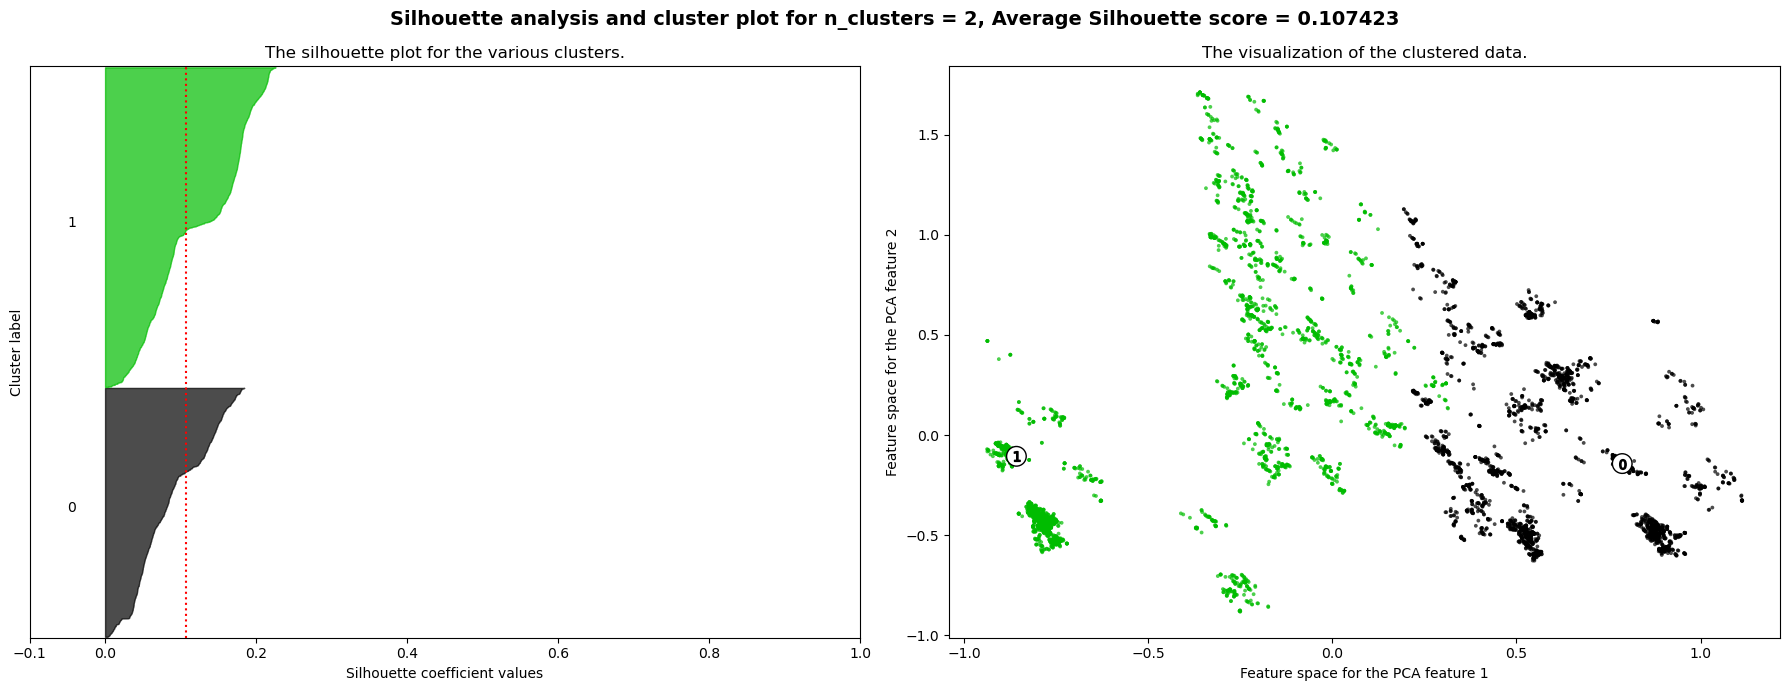

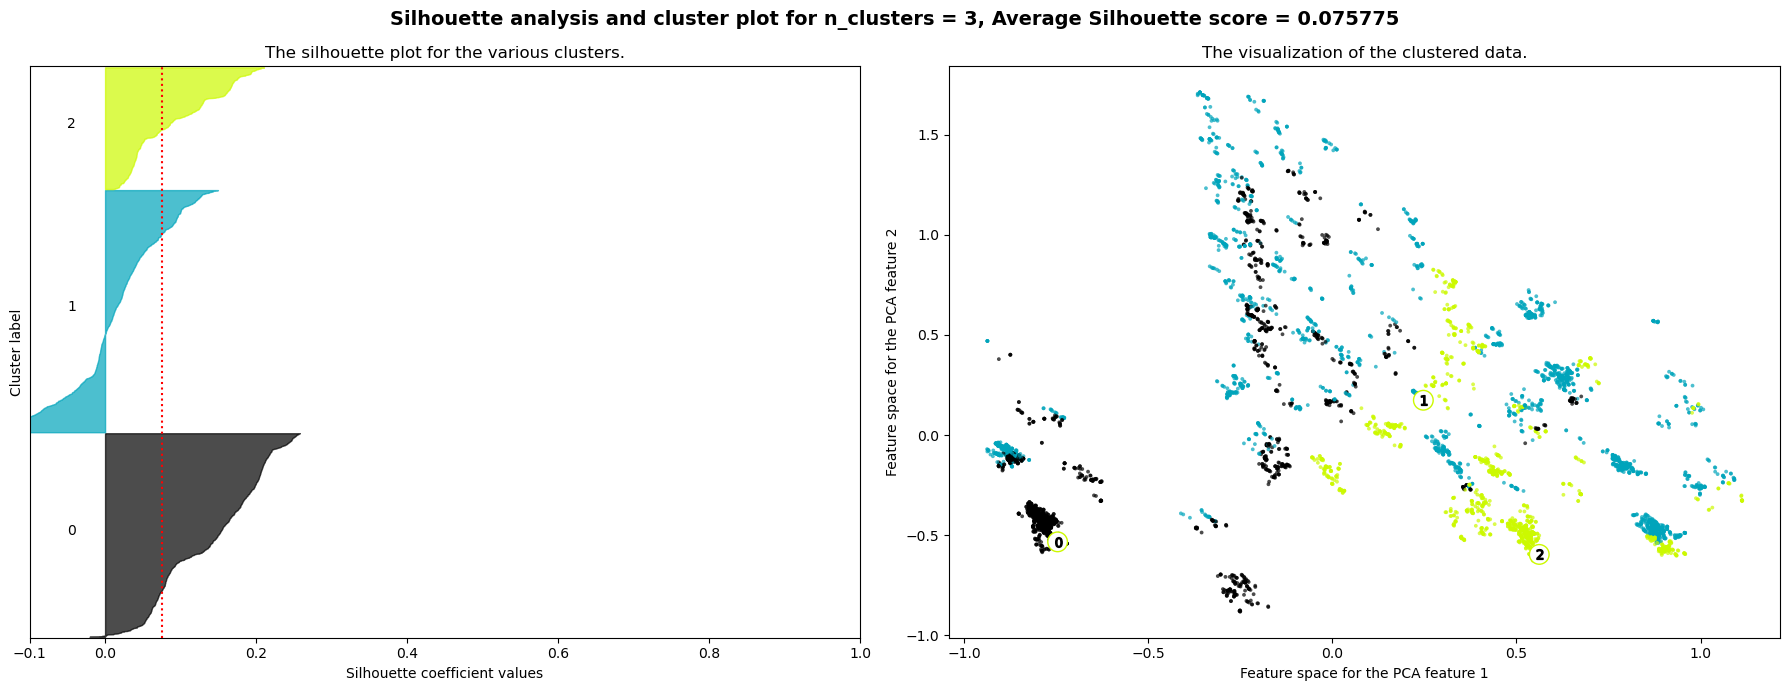

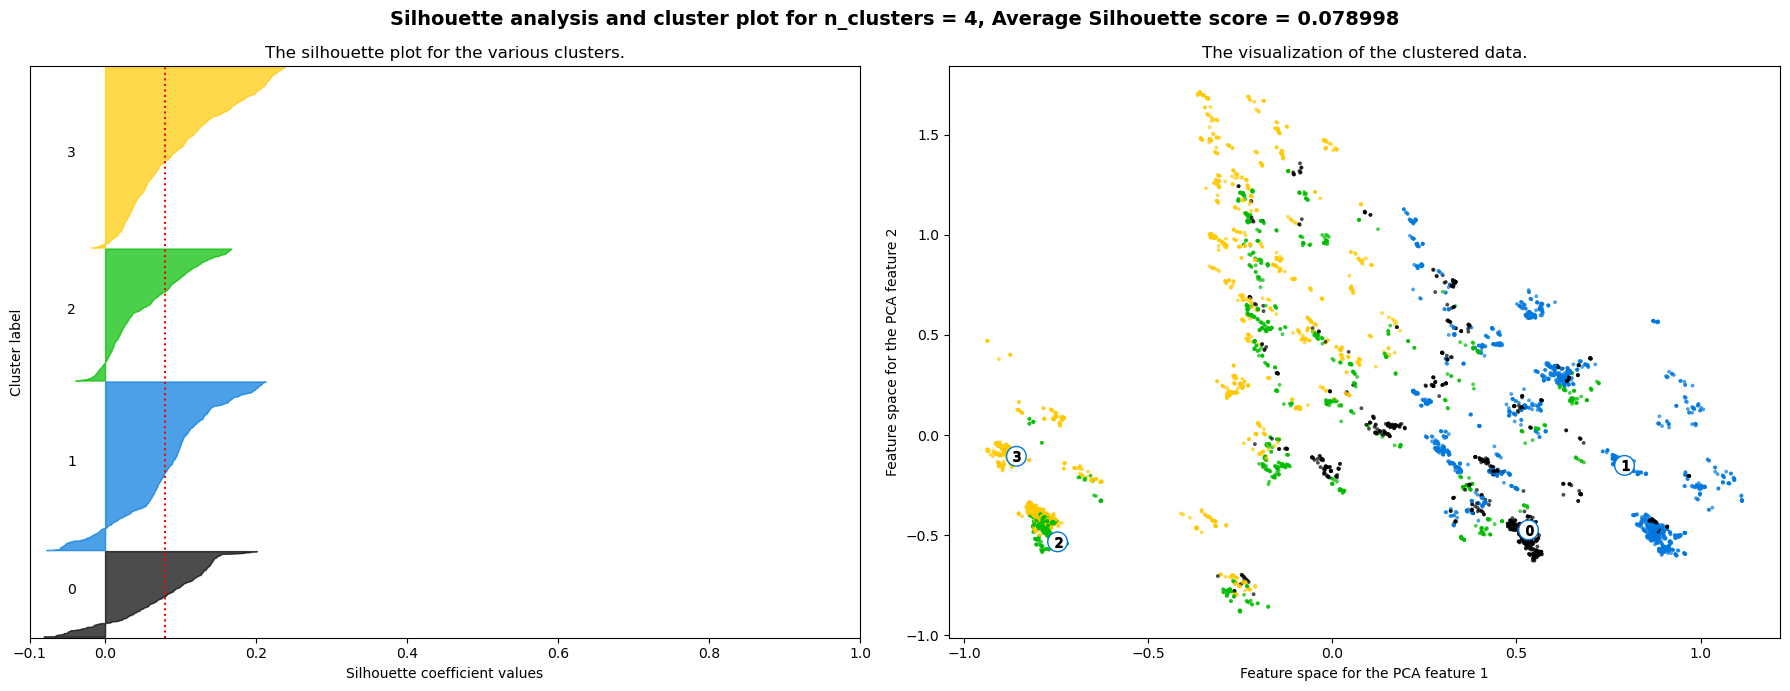

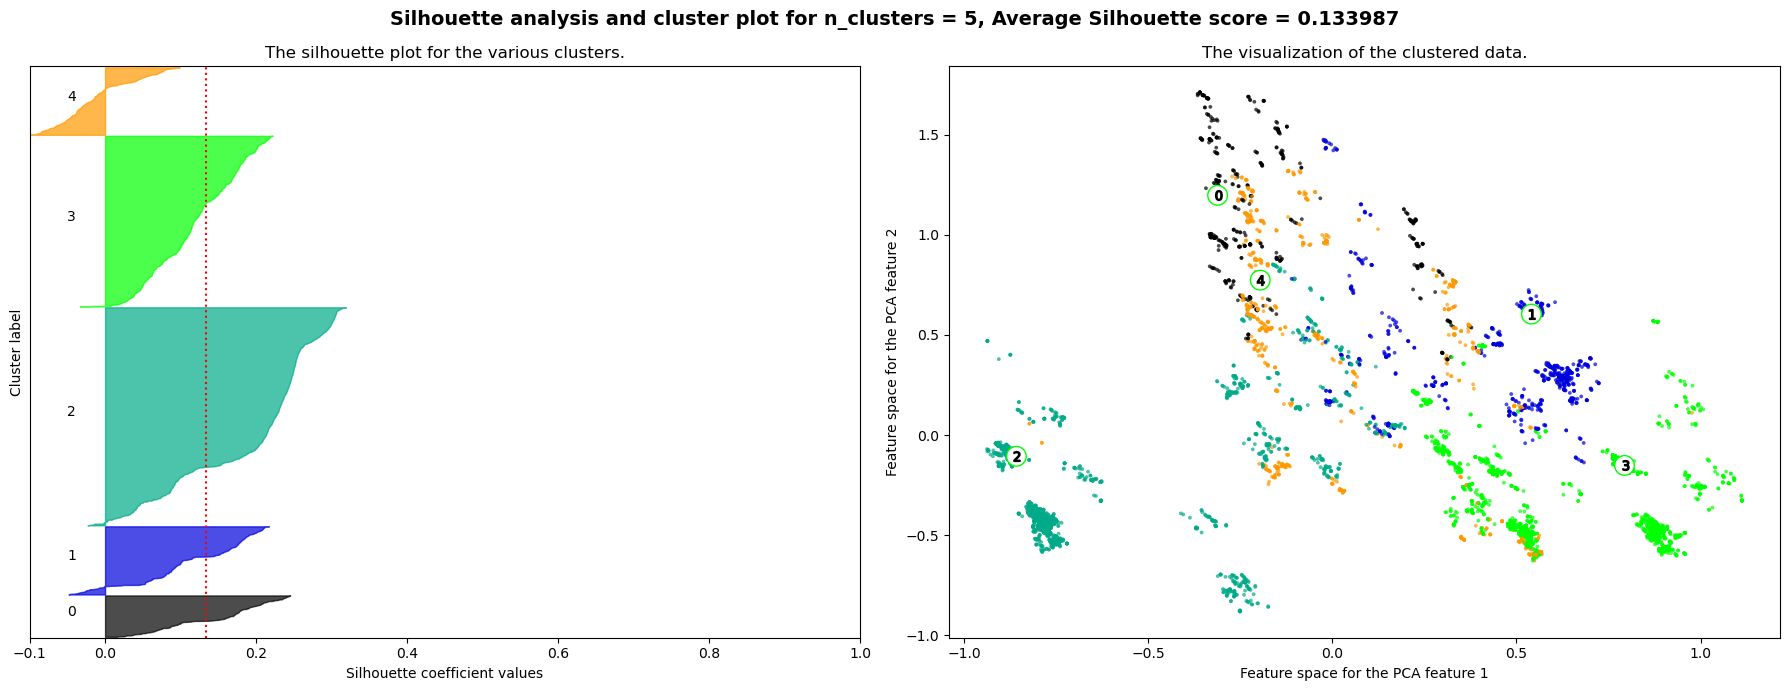

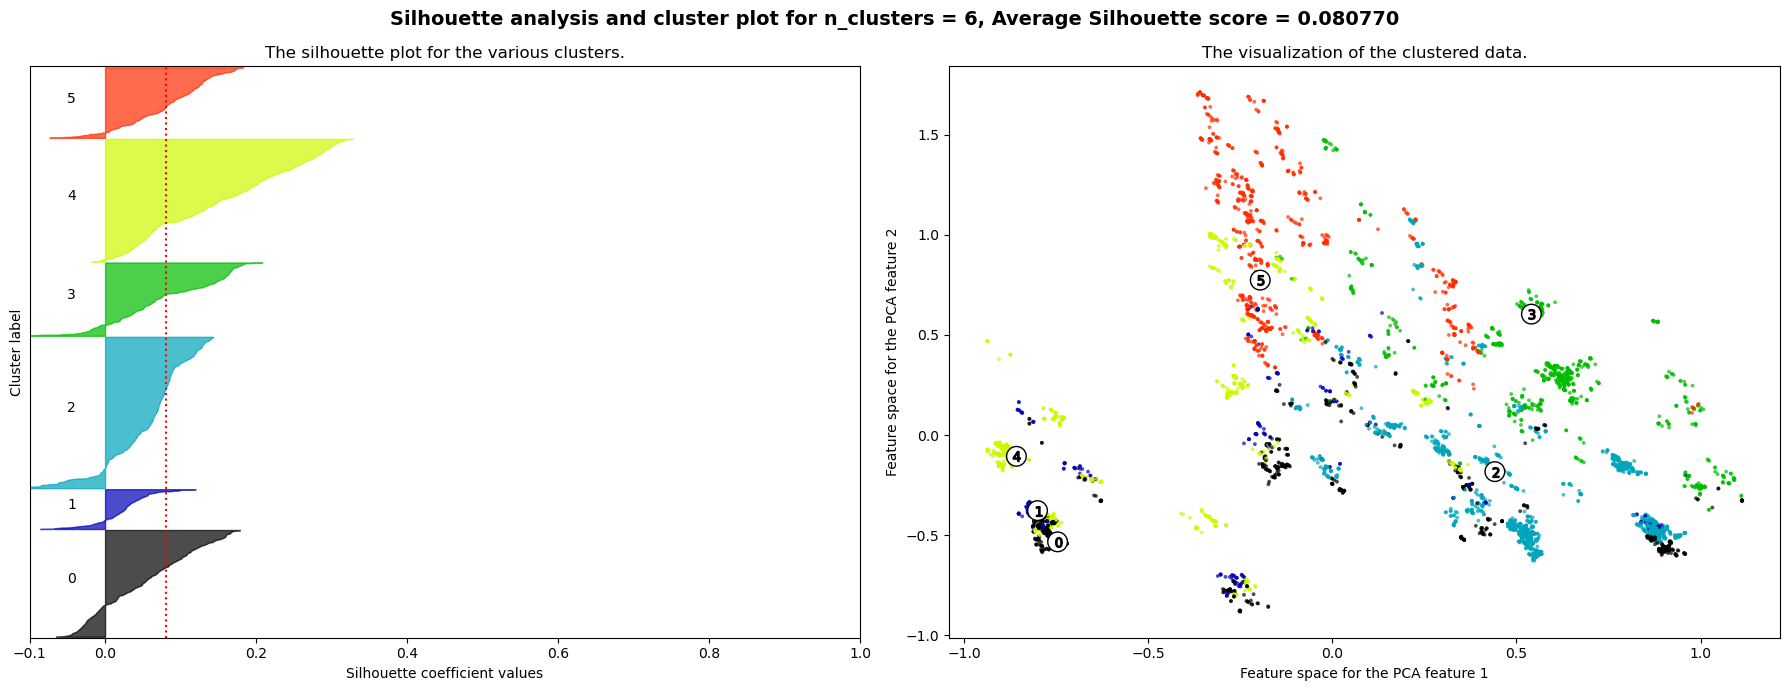

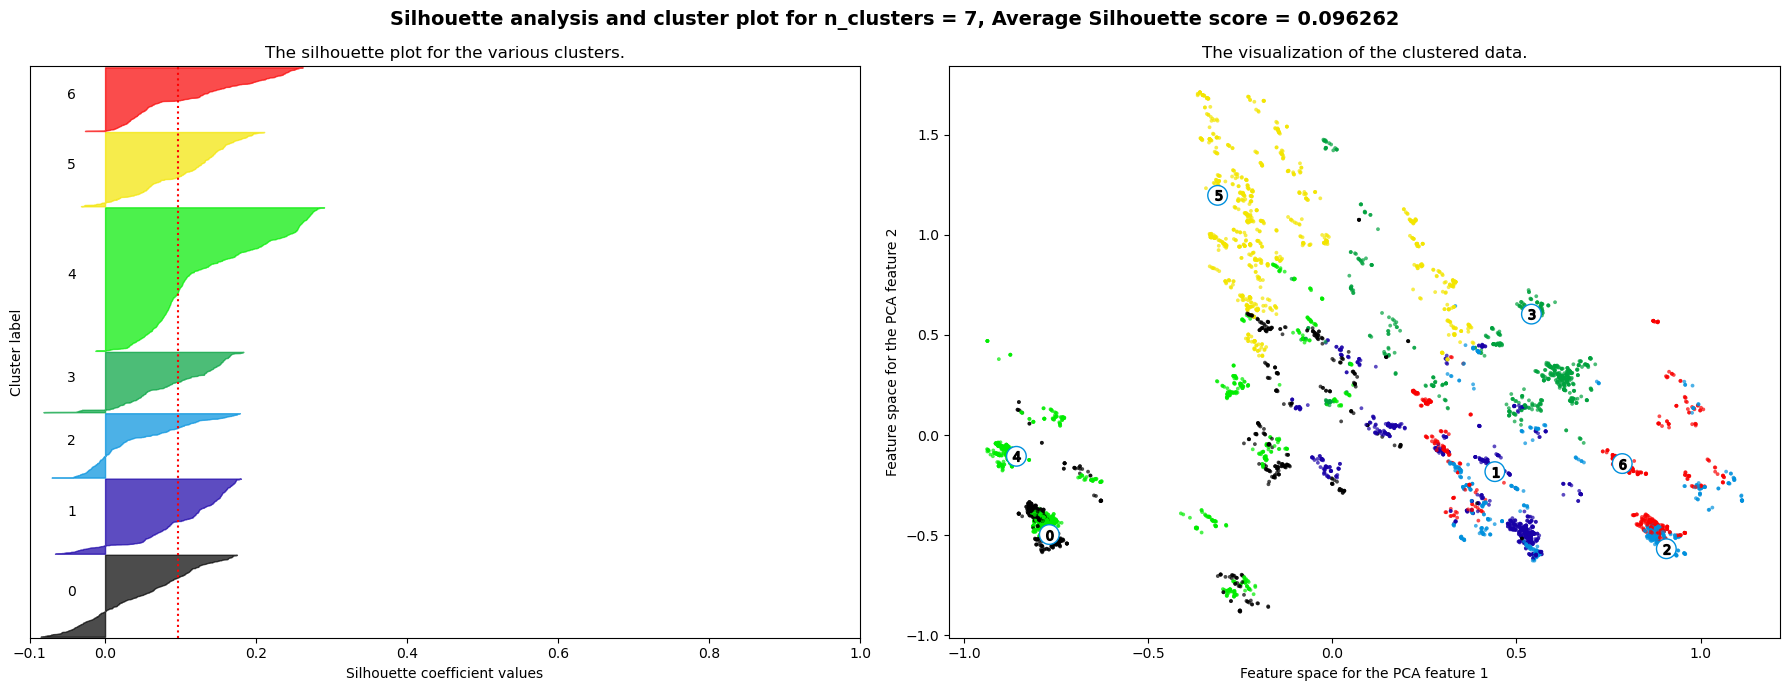

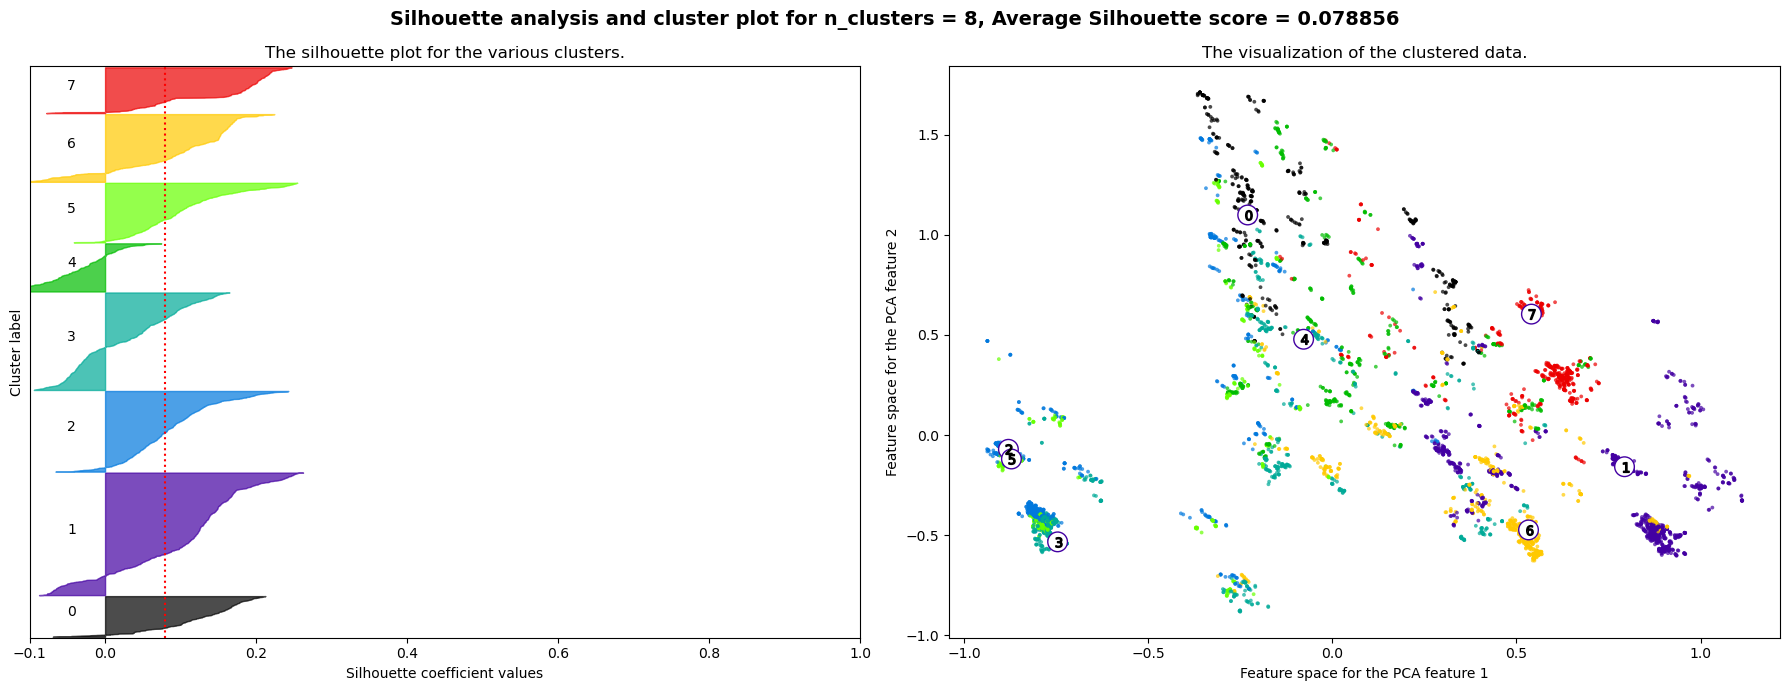

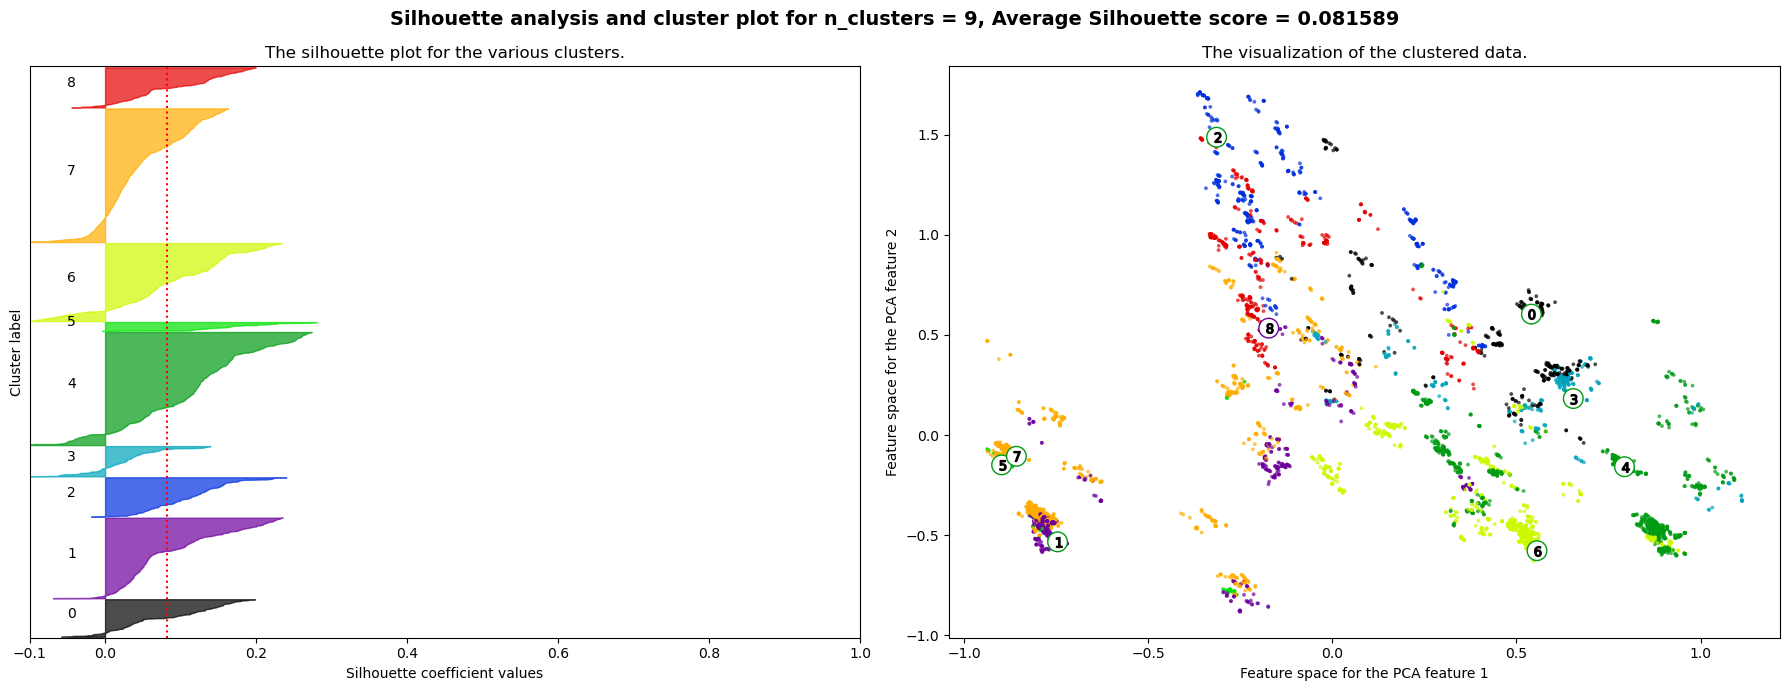

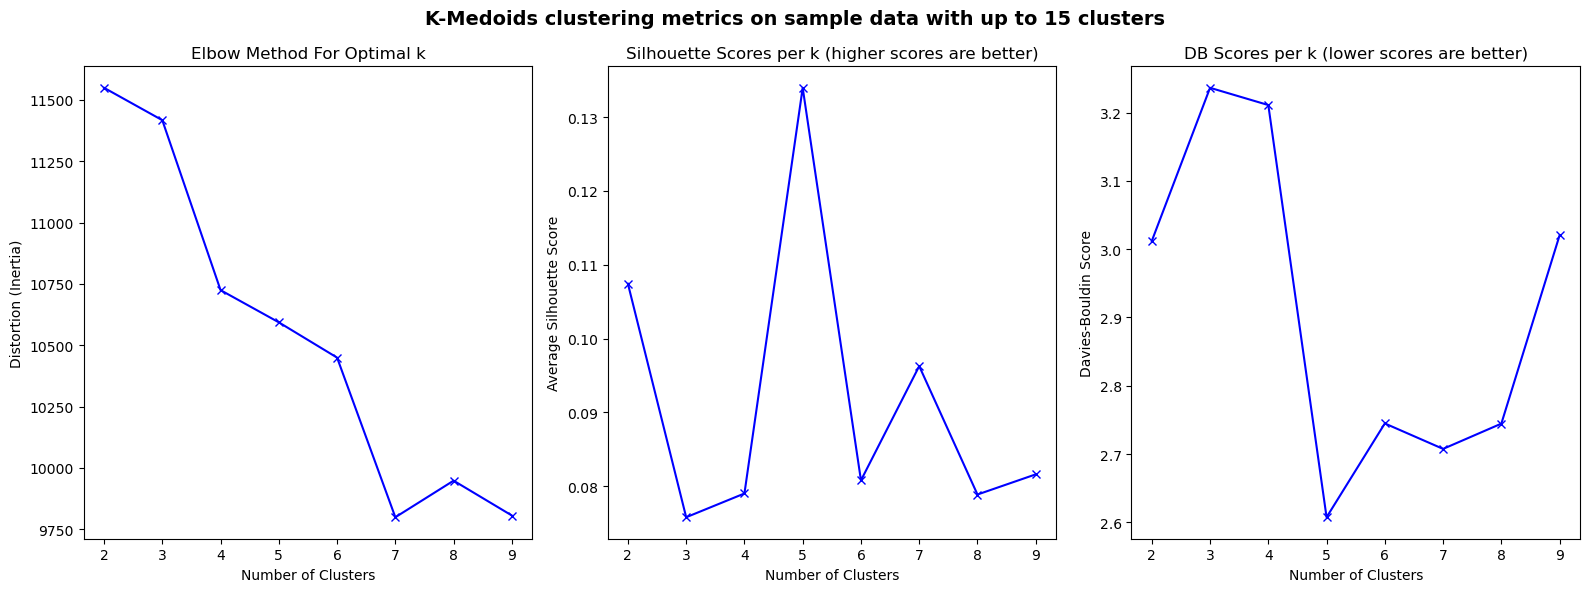

In [15]:
# Create a DataFrame of the results for further analysis downstream
non_pca_cluster_scores_df = pd.DataFrame()

# Compute clusters for the complete dataframe
non_pca_cluster_scores_df['Cluster Number'], non_pca_cluster_scores_df['Davies Bouldin'], non_pca_cluster_scores_df['Distortions (Inertia)'], non_pca_cluster_scores_df['Silhouette Average Scores'] = compute_clusters(complete_df)

In [16]:
# Function to perform PCA for the provided data
def perform_pca(input_data, name, n_comp):
    pca = PCA(n_components=n_comp, random_state=42)
    pca_out = pca.fit_transform(input_data)

    # Create a DataFrame with the principal components.
    columnz =[]

    for i in range(1,n_comp+1):
        columnz.append(name + '_pc'+str(i))
    
    out_df = pd.DataFrame(data=pca_out, columns=columnz)

    out_df['Country_Year'] = ori_df['Country_Year']
    out_df = out_df.reset_index(drop=True)
    out_df = out_df.set_index('Country_Year')
    return out_df

In [17]:
# Perform PCA on the complete_df, then analyze to determine the correct number of clusters.
complete_pca_df = perform_pca(complete_df, 'Complete', 6)

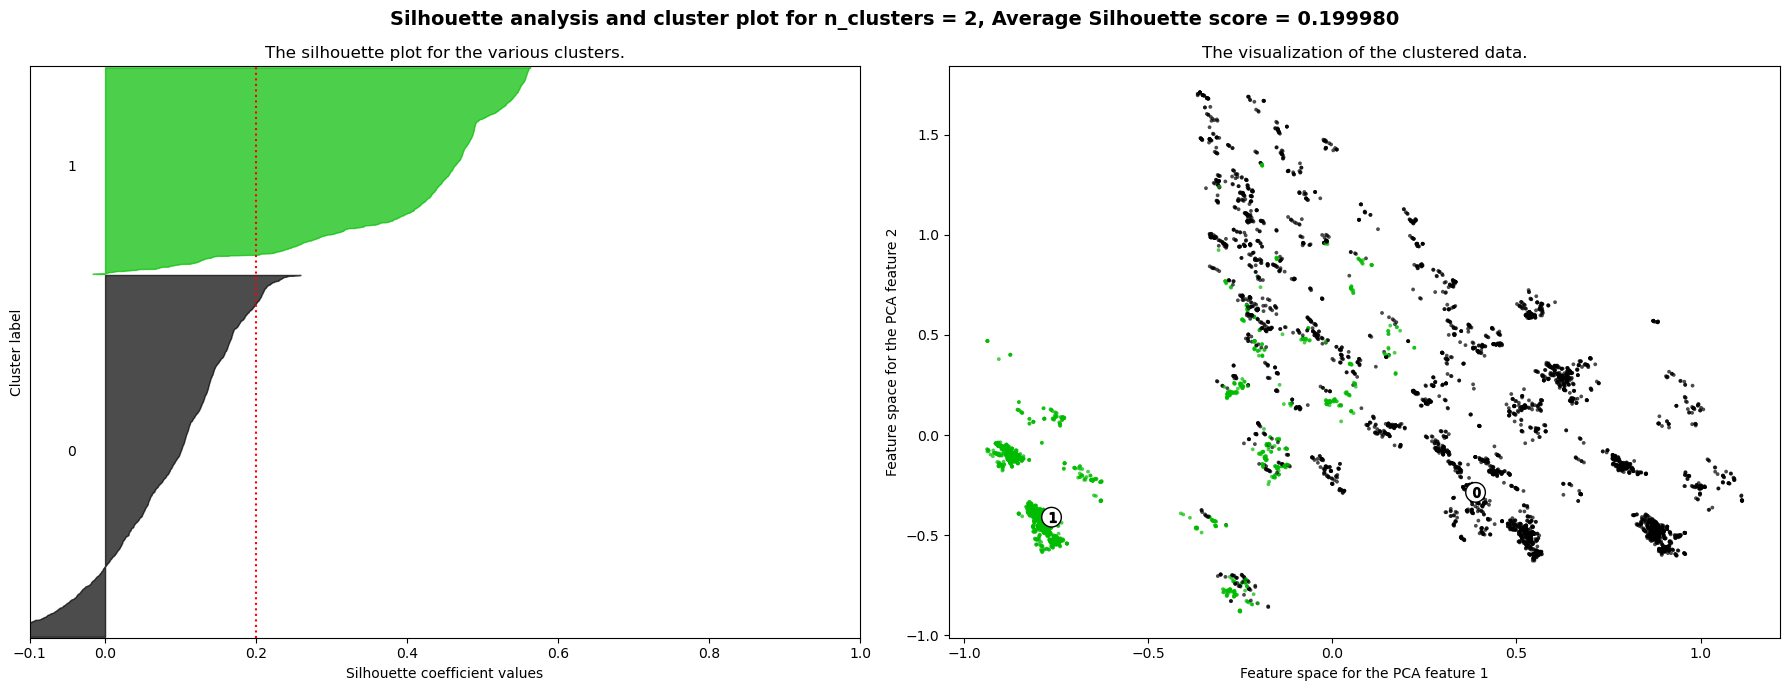

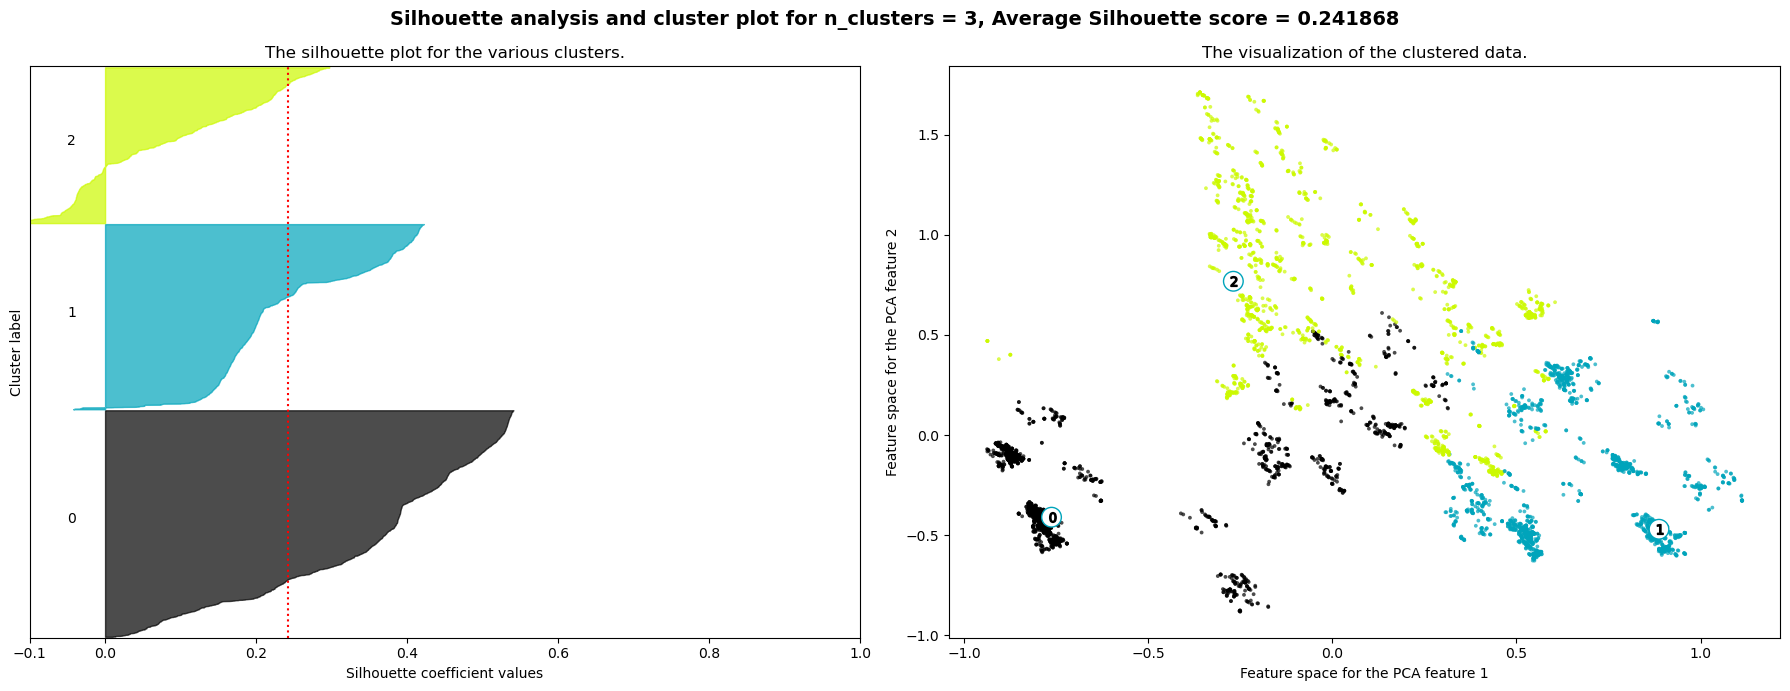

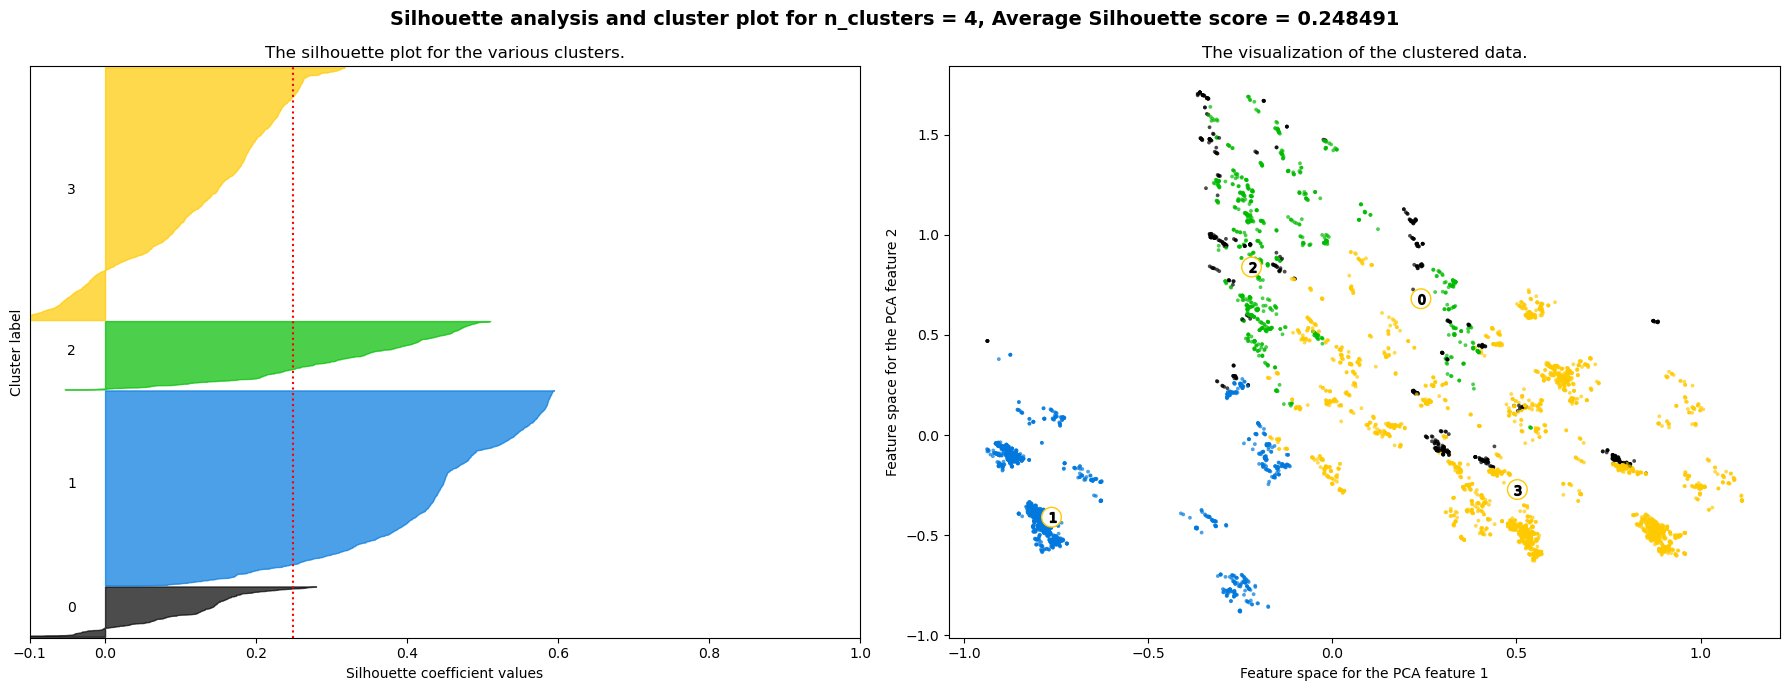

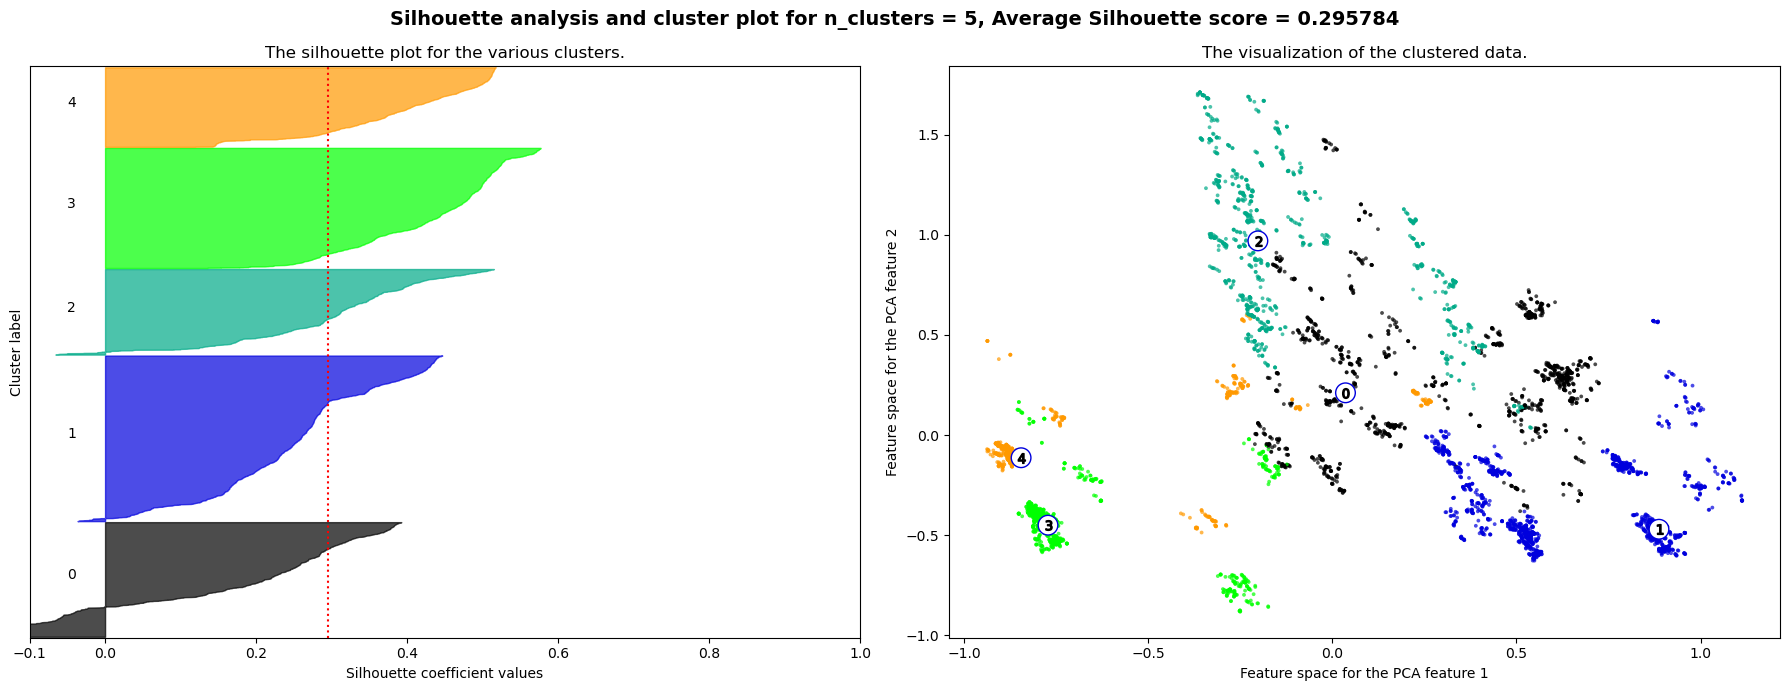

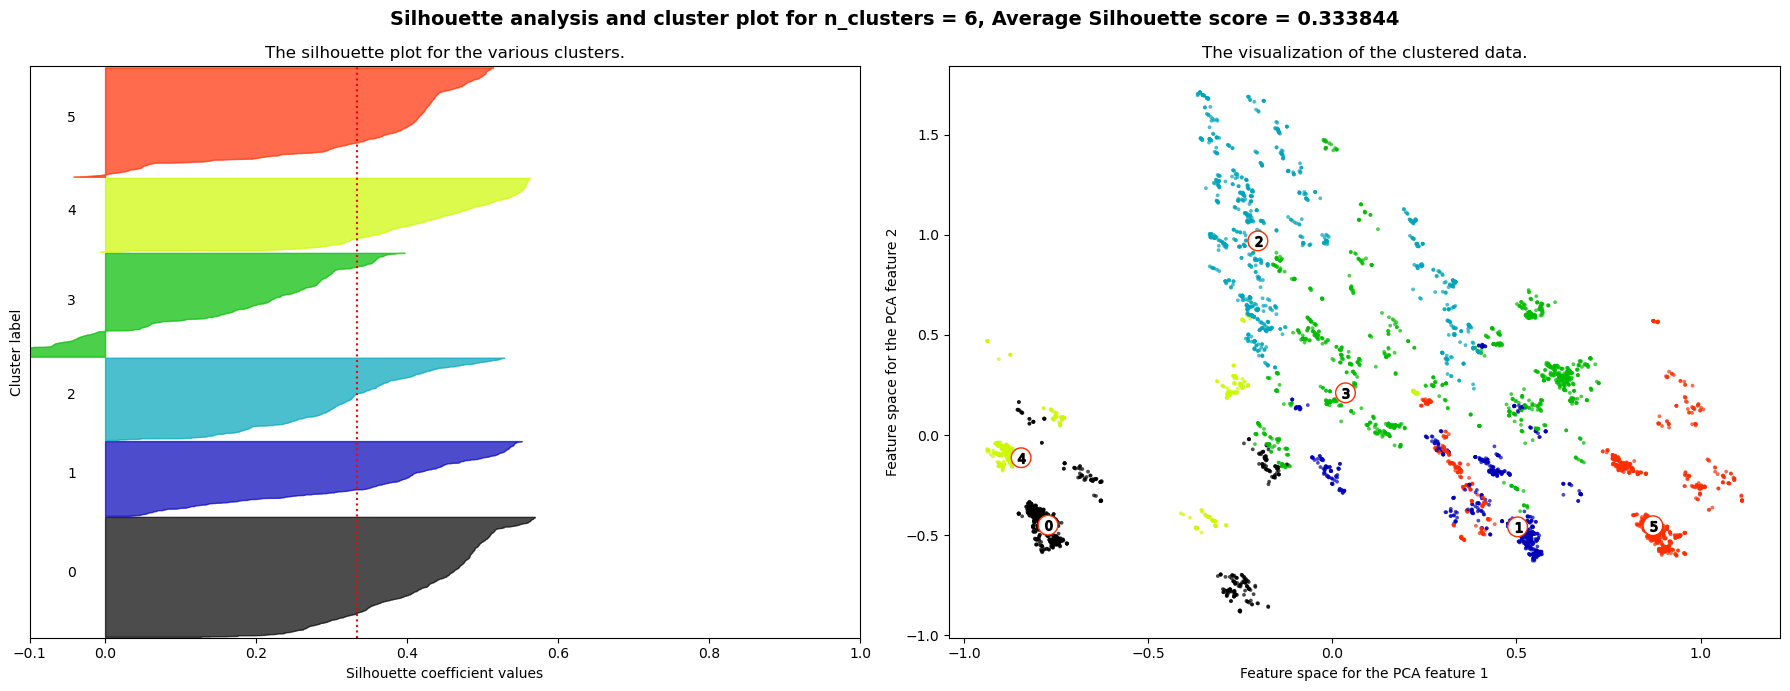

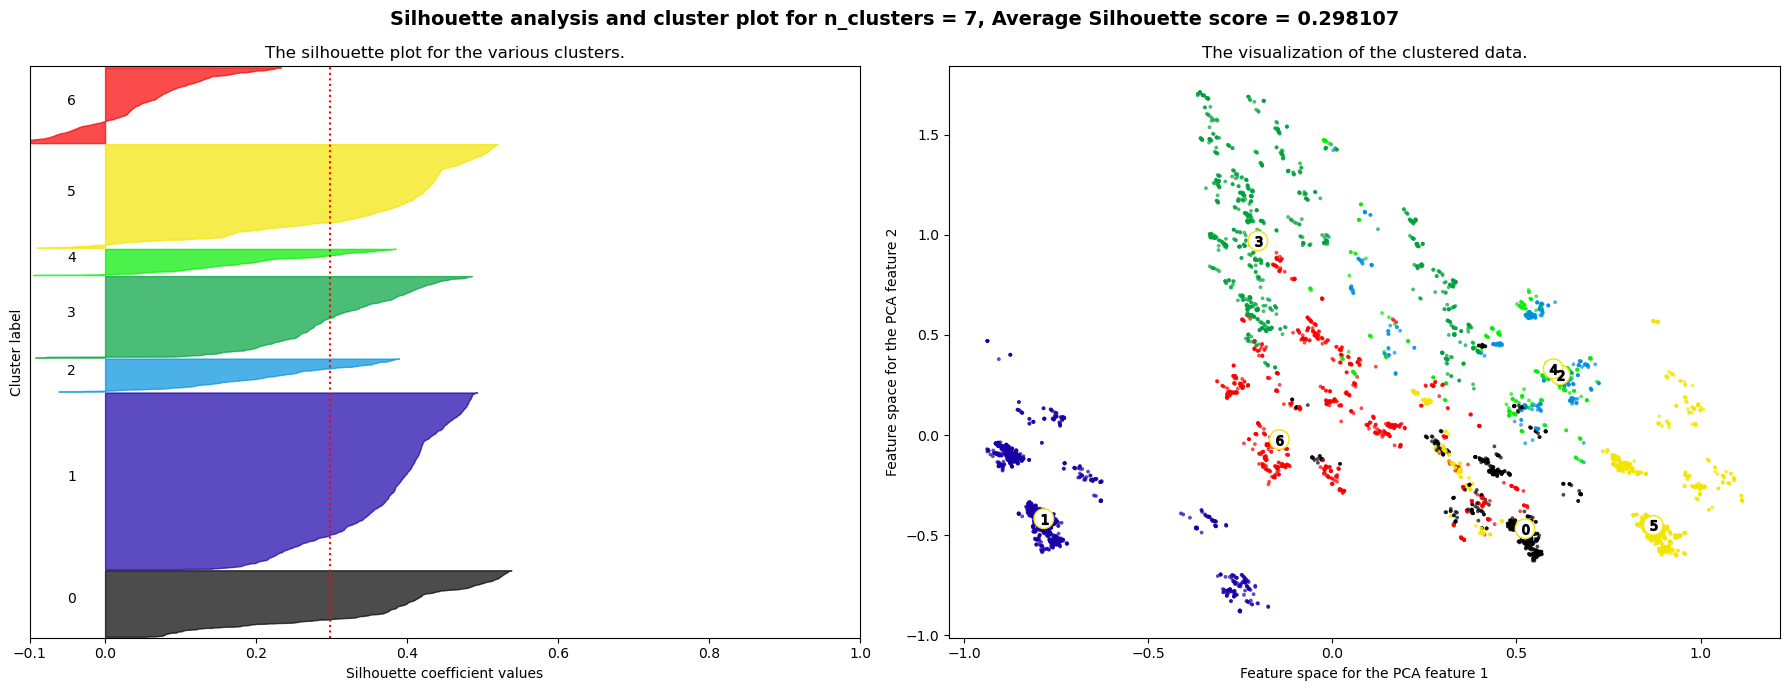

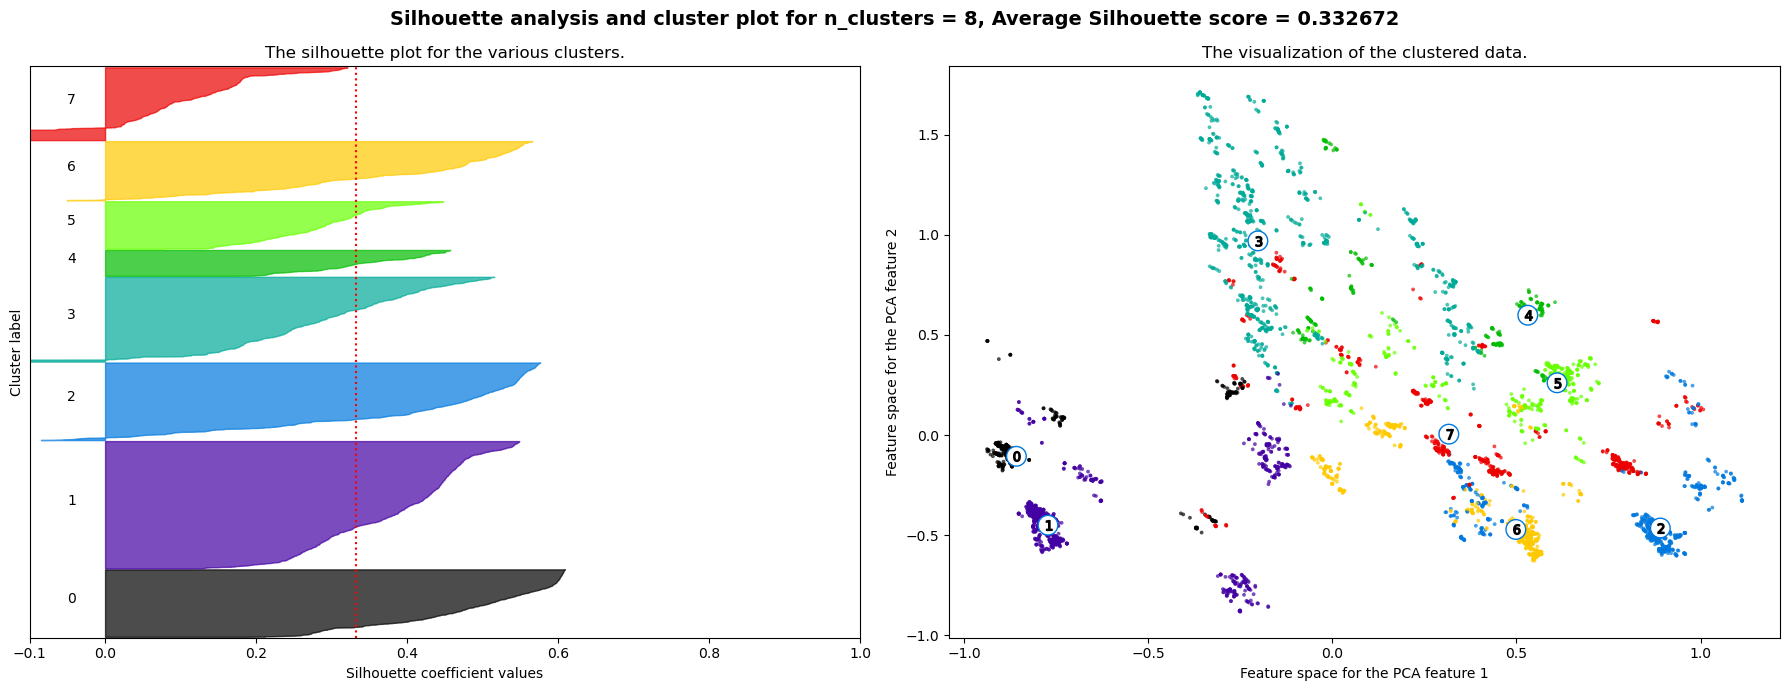

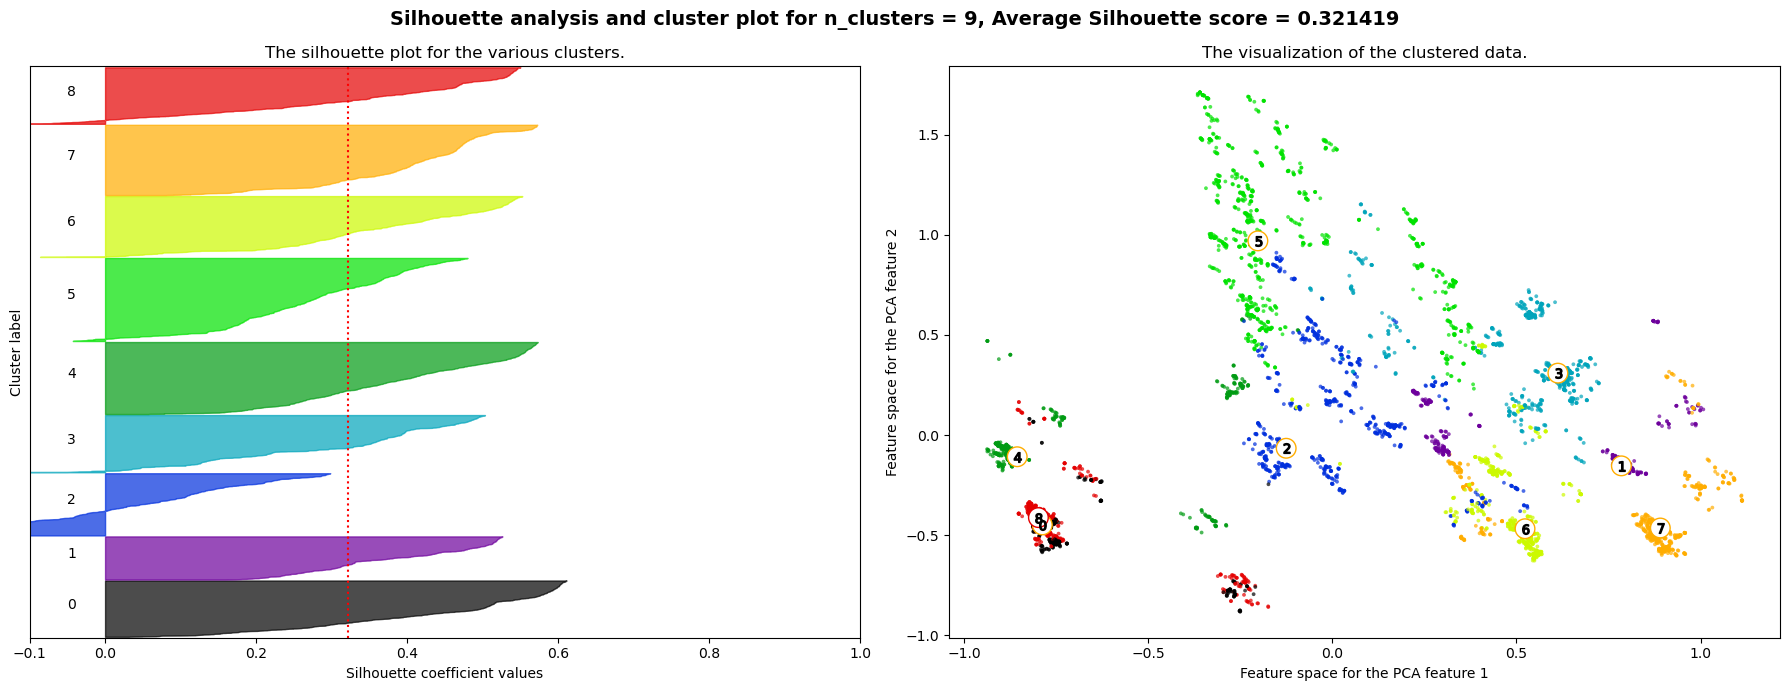

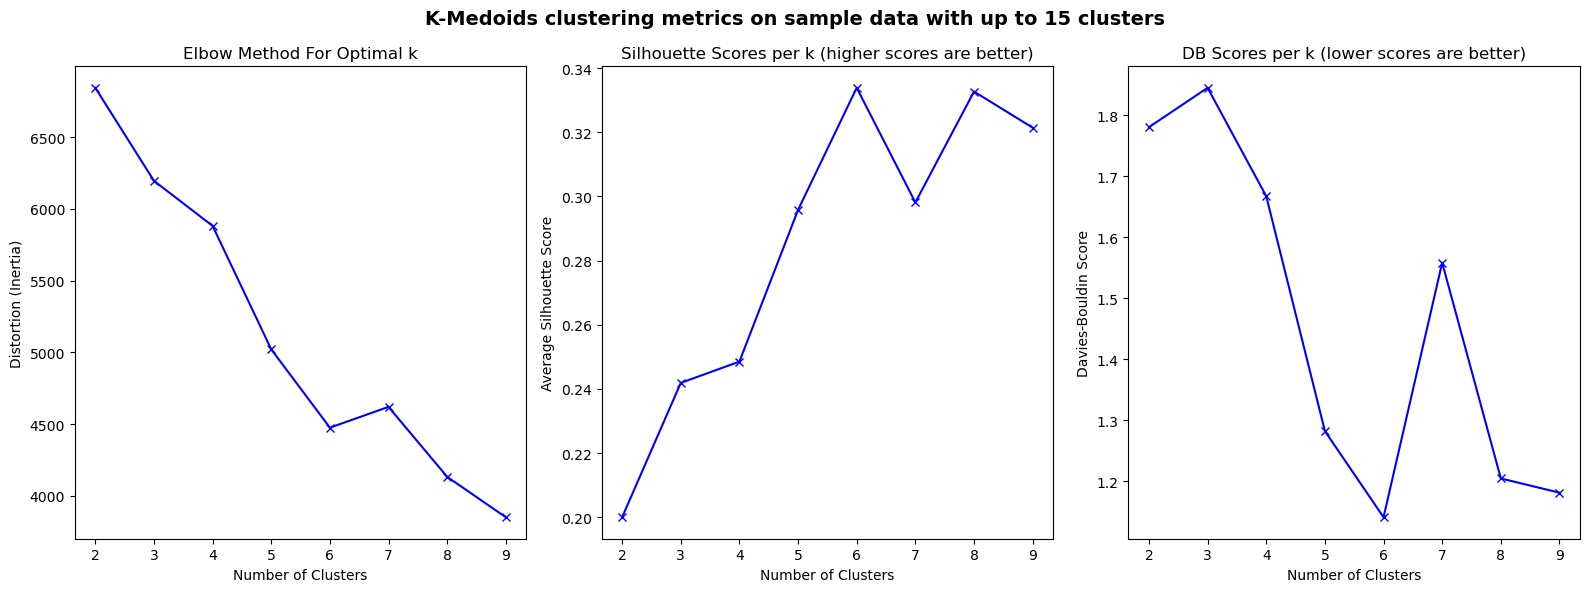

In [18]:
# Create a DataFrame of the results for further analysis downstream
pca_cluster_scores_df = pd.DataFrame()

# Compute clusters for the complete dataframe with PCA
pca_cluster_scores_df['Cluster Number'], pca_cluster_scores_df['Davies Bouldin'], pca_cluster_scores_df['Distortions (Inertia)'], pca_cluster_scores_df['Silhouette Average Scores'] = compute_clusters(complete_pca_df)

In [19]:
# define the model
cluster_model = KMedoids(n_clusters=14, init='k-medoids++')

# Fit the model - Make predictions
cluster_pred = cluster_model.fit_predict(complete_pca_df)

# Add the predicted class columns to the visualization dataset
viz_df['Cluster Label'] = cluster_model.labels_

In [20]:
# Add the Country_Year column to the dataframe, then run the profiling report
viz_df['Country-Year'] = viz_df.index

In [21]:
# Create a YData report to explore the feature relationships
cluster_profile = ProfileReport(viz_df, title='Pandas Profiling Report for Expect Life Redux', missing_diagrams={
          "heatmap": False, "bar": False, "matrix": False,})
cluster_profile.to_file('PCA_Complete_Cluster_KMedoids_Viz-Pandas_Profiling_Report.html')

# Produce the report in json format
json_data = cluster_profile.to_json()

# Save the json report as a file
cluster_profile.to_file('PCA_Complete_Cluster_KMedoids_Viz-Pandas_Profiling_Report.json')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Render JSON:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Principal Feature Analysis ###

In [22]:
non_pca_cluster_scores_df

,Cluster Number,Davies Bouldin,Distortions (Inertia),Silhouette Average Scores
0,2,3.011893,11549.060677,0.107423
1,3,3.236160,11417.023933,0.075775
2,4,3.210908,10724.461073,0.078998
3,5,2.607430,10593.200254,0.133987
4,6,2.744777,10449.419027,0.080770
5,7,2.707504,9798.786044,0.096262
6,8,2.744507,9947.900294,0.078856
7,9,3.020269,9805.873930,0.081589


In [23]:
pca_cluster_scores_df

,Cluster Number,Davies Bouldin,Distortions (Inertia),Silhouette Average Scores
0,2,1.780824,6844.819183,0.199980
1,3,1.845350,6196.201615,0.241868
2,4,1.667508,5882.170121,0.248491
3,5,1.282344,5021.657134,0.295784
4,6,1.141057,4475.388039,0.333844
5,7,1.558499,4620.139657,0.298107
6,8,1.204698,4132.562978,0.332672
7,9,1.181342,3850.803448,0.321419


### Define functions to select dataset features that provide relevant information for clustering. 
### Only important features are used to compute clusters.

In [44]:
# Define the prefilter function
def prefilter_features(df, threshold=0.008):
    """
    Prefilter features with low variance.
    """
    # Threshold can be set according to domain knowledge or exploratory analysis
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    
    # Return the dataframe with selected features
    return df[df.columns[selector.get_support(indices=True)]]
    

In [25]:
# Calculate entropy
def calculate_entropy(labels):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=2)


In [26]:
# Silhouette score adjusted by entropy
def clustering_score(df, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    labels = model.fit_predict(df)
    silhouette_avg = silhouette_score(df, labels)
    entropy_score = calculate_entropy(labels)
    return silhouette_avg / entropy_score


In [48]:
# Function to evaluate clusters with a set of features removed
def evaluate_feature_set(df, features_to_exclude, n_clusters):
    features_to_try = df.columns.difference(features_to_exclude)
    if len(features_to_try) == 0:
        return -1, [], n_clusters
    score = clustering_score(df[features_to_try], n_clusters)
    return score, features_to_try, n_clusters
    

In [53]:
# Principal Feature Analysis with parallel processing
def select_features_and_cluster_parallel(df, max_clusters=45, n_jobs=-1):
    # Prefilter features based on variance
    df_prefiltered = prefilter_features(df)
    
    # Calculate initial score with all features
    #initial_score, _ = evaluate_feature_set(df_prefiltered, [], 2)

    # Convert to list for indexing
    features_list = df_prefiltered.columns.tolist()
    
    num_features = len(features_list)
    selected_features = list(features_list)
    #current_score = initial_score
    current_score = -1
    #best_score = initial_score
    best_score = -1
    best_features = list(features_list)
    best_k = 2
    improvement = True

    # Parallel computation setup
    parallel = Parallel(n_jobs=n_jobs)

    while improvement and len(selected_features) > 1:
        improvement = False
        
        # This will generate a list of (score, feature_subset, k) for all combinations
        scores_features_k = parallel(delayed(evaluate_feature_set)(df_prefiltered, [f], k)
                                     for f in selected_features for k in range(2, max_clusters + 1))
        # Check if the list is not empty to avoid ValueError
        if not scores_features_k:
            break
                    
        # Find the best score, corresponding feature set and k
        best_score, best_features, best_k = max(scores_features_k, key=lambda item: (item[0], -len(item[1])))

        if best_score > current_score:
            current_score = best_score
            improvement = True
        
        # Remove one feature (with the worst score) at a time for the next round
        scores_features = sorted(scores_features_k, key=lambda item: item[0])
        if scores_features:  # Check if there are features scored
            lowest_score, worst_features, _ = scores_features[0]
            if worst_features[0] in selected_features:
                selected_features.remove(worst_features[0])  # Remove worst feature for the next iteration

    # Output results
    print("Best number of clusters:", best_k)
    print("Best subset of features by index:", best_features)
    return best_k, best_features
    

In [54]:
# Run the experiment using the complete (non-pca) dataframe
best_k, best_features = select_features_and_cluster_parallel(complete_df)

Best number of clusters: 2
Best subset of features by index: Index(['Alcohol Use per capita (liters)', 'Avg Rainfall (mm/yr)',
       'Capital HE (% GDP)', 'Current HE (% GDP)',
       'Current HE per capita (PPP Intl $)', 'Daily Caloric Supply',
       'Doctors (#/10k pop)', 'Domestic General Gov HE (% GDP)',
       'Domestic General Gov HE per capita (PPP Intl $)',
       'Electricity Access (% Pop)', 'Employer-liability system',
       'Employer-liability system (cash benefits)',
       'Employer-liability system (cash maternity benefits)',
       'Employer-liability system (cash medical benefits)',
       'Employer-liability system (cash sickness benefits)',
       'Employer-liability system (maternity benefits)',
       'Employer-liability system (medical benefits)',
       'Employer-liability system (paternity benefits)',
       'Employer-liability system (sickness benefits)',
       'Employment-related system (cash maternity benefits)',
       'Employment-related system (parenta

### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
perf_data = db['Supervised_Performance_Data']

In [ ]:
# Create a dictionary to send to MongoDB - Alternate method, not necessary when using PyMongoArrow
perf_dict = performance_df.to_dict('records')
print(perf_dict)

# write the data to the database (alternate method)
perf_data.insert_many(perf_dict)